In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,os,glob,pickle
import datetime
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import yaml,logging
from datetime import timedelta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
start = datetime.datetime.now()
path = 'C:/Users/ebhavar/OneDrive - Ericsson AB/Desktop/DeleteMe/Python/CaseStudy/FRA- Masked Sample Data - V1/'
mgr_leaves = pd.read_excel(path+'Leave Records Report.xlsx', sheet_name = 'Sheet3')
mgr_active_emp = pd.read_excel(path+'Managers- Active Employees.xlsx', sheet_name = 'Active Employees')
mgr_certs = pd.read_excel(path+'Managers- Active Employees.xlsx', sheet_name = 'Certifications')
mgr_perfTier = pd.read_excel(path+'Managers- Active Employees.xlsx', sheet_name = 'Performance Tier')
mgr_edu = pd.read_excel(path+'Managers- Active Employees.xlsx', sheet_name = 'Education')
mgr_workex = pd.read_excel(path+'Managers- Active Employees.xlsx', sheet_name = 'Work Experience')
end_time = datetime.datetime.now()
print("Time Consumed in reading Files--> ",(end_time-start))

Time Consumed in reading Files-->  0:00:02.983558


In [3]:
## Counting the total certification for Employee
mgr_certs = mgr_certs.groupby('LPN').count()[['Employee Status','Designation']]
mgr_certs = mgr_certs.rename(columns={'Employee Status':'Count_Certifications'}).reset_index()
mgr_certs.sample(5)

,LPN,Count_Certifications,Designation
23,5323131,2,2
9,3322079,1,1
21,5316058,1,1
1,2322764,1,1
5,2328879,1,1


In [4]:
df = pd.merge(left=mgr_active_emp,right=mgr_certs[['LPN','Count_Certifications']],on='LPN',how='left')
print("Shape of mgr_active_emp :",mgr_active_emp.shape)
print("Shape after Merge certs :",df.shape)
df.sample(5)

Shape of mgr_active_emp : (156, 14)
Shape after Merge certs : (156, 15)


,LPN,Employee Status,Designation,Band,Service Line,Sub Service Line,Work Location,Work Location City,Country/Region,Date Of Birth,Gender,Last Promotion Date,Joining Date,Most Recent Hire Date,Count_Certifications
59,4323881,Active,Manager,3,Service Line 1,Sub Service Line 1,India,NaN,India,1984-03-25,Gender 2,NaT,2019-07-01,2019-07-01,NaN
68,1326863,Active,Manager,1,Service Line 1,Sub Service Line 1,India,NaN,India,1991-06-10,Gender 1,NaT,2021-04-19,2021-04-19,NaN
54,5329170,Active,Manager,2,Service Line 5,Sub Service Line 10,India,NaN,India,1989-10-12,Gender 1,NaT,2022-02-07,2022-03-01,NaN
14,4326931,Active,Manager,1,Service Line 4,Sub Service Line 8,India,NaN,India,1989-04-17,Gender 1,NaT,2021-04-14,2021-04-14,NaN
109,5322691,Active,Manager,1,Service Line 3,Sub Service Line 6,India,NaN,India,1991-03-22,Gender 1,2021-10-01,2018-07-23,2018-07-23,NaN


In [5]:
# Merging the Performance Data:
df2 = pd.merge(left=df,right=mgr_perfTier[['LPN','Performance Rating 2020','Performance Rating 2021']],on='LPN',how='left')
print("Shape of mgr_active_emp :",df.shape)
print("Shape after PerformaceRating :",df2.shape)
df2.sample(5)

Shape of mgr_active_emp : (156, 15)
Shape after PerformaceRating : (156, 17)


,LPN,Employee Status,Designation,Band,Service Line,Sub Service Line,Work Location,Work Location City,Country/Region,Date Of Birth,Gender,Last Promotion Date,Joining Date,Most Recent Hire Date,Count_Certifications,Performance Rating 2020,Performance Rating 2021
90,5325319,Active,Manager,2,Service Line 3,Sub Service Line 6,India,NaN,India,1977-10-13,Gender 1,NaT,2020-02-10,2020-02-10,3.0,4,0
20,3318681,Active,Manager,2,Service Line 1,Sub Service Line 1,India,NaN,India,1990-05-14,Gender 2,2020-10-01,2015-05-18,2015-05-18,1.0,5,5
18,4327636,Active,Manager,1,Service Line 3,Sub Service Line 7,India,NaN,India,1991-10-04,Gender 1,NaT,2021-08-16,2021-08-16,NaN,5,2
13,3324307,Active,Manager,3,Service Line 1,Sub Service Line 2,India,NaN,India,1979-01-09,Gender 1,NaT,2019-08-26,2019-08-26,NaN,2,5
131,4320825,Active,Manager,1,Service Line 2,Sub Service Line 4,India,NaN,India,1991-10-29,Gender 1,2021-10-01,2016-11-28,2016-11-28,NaN,2,4


In [6]:
### WOrking on the Education Section. Few entries are duplicated like where people have completed Bachelor's and Master's Degree
# Concat Degree if duplicate
mgr_edu_temp = mgr_edu.groupby(['LPN'])['Degree'].transform(lambda x: ','.join(x))
# Creating DF from Series
mgr_edu_temp = pd.DataFrame({'Concat_Degree':mgr_edu_temp.values})
mgr_edu=pd.concat([mgr_edu,mgr_edu_temp],axis=1)
def find_highest_education(Concat_Degree):
    if 'doctorate' in Concat_Degree.lower():
        return "Doctorate's Degree"
    if 'master' in Concat_Degree.lower():
        return "Master's Degree"
    elif 'bachelor' in Concat_Degree.lower():
        return "Bachelor's Degree"
    elif 'associate' in Concat_Degree.lower():
        return "Associate's Degree"
    elif 'technical' in Concat_Degree.lower():
        return "Technical Diploma"
    else:
        return Concat_Degree
mgr_edu['Education'] = mgr_edu.apply(lambda x: find_highest_education(x.Concat_Degree), axis=1)
##Dropping Duplicates
mgr_edu = mgr_edu.drop_duplicates(subset= ['LPN'],keep='first').reset_index(drop=True)

### Merging the Education Data with Raw Data:
df3 = pd.merge(left=df2,right=mgr_edu[['LPN','Education']],on='LPN',how='left')
print("Shape of mgr_active_emp :",df.shape)
print("Shape after PerformaceRating :",df3.shape)
df3.sample(3)

Shape of mgr_active_emp : (156, 15)
Shape after PerformaceRating : (156, 18)


,LPN,Employee Status,Designation,Band,Service Line,Sub Service Line,Work Location,Work Location City,Country/Region,Date Of Birth,Gender,Last Promotion Date,Joining Date,Most Recent Hire Date,Count_Certifications,Performance Rating 2020,Performance Rating 2021,Education
81,1323331,Active,Manager,1,Service Line 4,Sub Service Line 9,India,NaN,India,1992-05-16,Gender 1,2020-10-01,2012-07-09,2019-01-07,NaN,0,2,Bachelor's Degree
71,3318287,Active,Manager,2,Service Line 1,Sub Service Line 2,India,NaN,India,1992-06-25,Gender 2,2020-10-01,2015-02-02,2015-02-02,NaN,0,2,Bachelor's Degree
110,1327336,Active,Manager,1,Service Line 4,Sub Service Line 8,India,NaN,India,1985-10-02,Gender 1,NaT,2021-07-19,2021-07-19,1.0,4,2,Bachelor's Degree


In [7]:
## WOrking on Manager Experience:
# We have given start dates and end dates of comparines where Managers have periously worked on
# Now since there are duplicate LPNs so first checking unique Employee Ids
print("Total # of Employees in Workex Sheet :",len(mgr_workex.LPN.unique().tolist()))

#Creating a new Dataframe which will hold experience information of Employe
df_work_ex = pd.DataFrame(columns=['LPN','Experience_In_Months','Companies_Switched','Previous Employment Start Date','Previous Employment End Date'])
def calculate_exp(index,df_temp):
    #print("LPN :",df_temp[df_temp['LPN']])
    df_temp = df_temp.sort_values(by='Previous Employment Start Date',ascending=True)
    shape = df_temp.shape
    #print(df_temp.shape)
    if df_temp.shape[0]==1:
        start_date = df_temp.iloc[0]['Previous Employment Start Date']
        #start_date = datetime.strptime(df_temp.iloc[0]['Previous Employment Start Date'], '%Y-%m-%d')
        #end_date = datetime.strptime(df_temp.iloc[0]['Previous Employment End Date'], '%Y-%m-%d')
        end_date = df_temp.iloc[0]['Previous Employment End Date']
        diff_in_months = (end_date-start_date)/np.timedelta64(1, 'M')
        #df['nb_months'] = ((df.dates1 - df.dates2)/np.timedelta64(1, 'M'))
        #print("Months: ",diff_in_months)
        companies_switched = 1
        relevant_work_ex = df_temp.iloc[0]['Previous Relevant Work Experience (Y/N)']
    else:
        start_date = df_temp.iloc[0]['Previous Employment Start Date']
        end_date = df_temp.iloc[(df_temp.shape[0]-1)]['Previous Employment End Date']
        diff_in_months = (end_date-start_date)/np.timedelta64(1, 'M')
        companies_switched = df_temp['Previous Company  Name'].nunique()
        relevant_work_ex = df_temp.iloc[(df_temp.shape[0]-1)]['Previous Relevant Work Experience (Y/N)']
    df_work_ex.loc[index,['LPN']] = df_temp.iloc[0]['LPN']
    df_work_ex.loc[index,['Experience_In_Months']] = (round(diff_in_months, 0))
    df_work_ex.loc[index,['Companies_Switched']] = companies_switched
    df_work_ex.loc[index,['Previous Employment Start Date']] = start_date
    df_work_ex.loc[index,['Previous Employment End Date']] = end_date
    df_work_ex.loc[index,['Previous Relevant Work Experience (Y/N)']] = relevant_work_ex
index=0
for each_LPN in mgr_workex.LPN.unique().tolist():
    df_temp = mgr_workex[mgr_workex['LPN']==each_LPN]
    calculate_exp(index,df_temp)
    index+=1
df_work_ex.sample(3)

Total # of Employees in Workex Sheet : 161


,LPN,Experience_In_Months,Companies_Switched,Previous Employment Start Date,Previous Employment End Date,Previous Relevant Work Experience (Y/N)
16,2328040,NaN,2,2016-06-01 00:00:00,NaT,Yes
54,2322764,38.0,1,2015-07-16 00:00:00,2018-09-12 00:00:00,Yes
129,2329324,NaN,1,NaT,NaT,NaN


In [8]:
### Merging the WOrkEx information in the Master Data:
# Merging the Performance Data:
df4 = pd.merge(left=df3,right=df_work_ex[['LPN','Experience_In_Months','Companies_Switched','Previous Relevant Work Experience (Y/N)']],on='LPN',how='left')
print("Shape of mgr_active_emp :",df3.shape)
print("Shape after PerformaceRating :",df4.shape)
df4.sample(5)

Shape of mgr_active_emp : (156, 18)
Shape after PerformaceRating : (156, 21)


,LPN,Employee Status,Designation,Band,Service Line,Sub Service Line,Work Location,Work Location City,Country/Region,Date Of Birth,Gender,Last Promotion Date,Joining Date,Most Recent Hire Date,Count_Certifications,Performance Rating 2020,Performance Rating 2021,Education,Experience_In_Months,Companies_Switched,Previous Relevant Work Experience (Y/N)
149,2328511,Active,Manager,3,Service Line 3,Sub Service Line 7,India,NaN,India,1972-10-21,Gender 1,NaT,2021-10-25,2021-10-25,NaN,0,0,Master's Degree,NaN,1,NaN
88,3328462,Active,Manager,3,Service Line 3,Sub Service Line 7,India,NaN,India,1980-11-06,Gender 2,NaT,2022-01-03,2022-01-03,NaN,5,0,Bachelor's Degree,NaN,1,NaN
122,4328126,Active,Manager,1,Service Line 5,Sub Service Line 11,India,NaN,India,1991-04-09,Gender 1,NaT,2021-11-03,2021-11-03,NaN,1,2,Bachelor's Degree,24.0,1,NaN
1,2329008,Active,Manager,3,Service Line 5,Sub Service Line 11,India,NaN,India,1990-08-10,Gender 2,NaT,2022-03-01,2022-03-01,NaN,1,1,Bachelor's Degree,NaN,1,NaN
137,4326668,Active,Manager,3,Service Line 5,Sub Service Line 10,India,NaN,India,1990-08-14,Gender 1,NaT,2021-04-26,2021-04-26,NaN,0,5,Bachelor's Degree,NaN,3,NaN


In [9]:
### Working with the leave record Data:
mgr_leaves

,LPN,Designation,Grade - Code (Sort By),Start Date,End Date,Leave Date,Leave Type,Days,Total Days,Conse\ncutive
0,320230,Manager,1,2020-11-16,2020-11-16,2020-11-16,Full Day,1.0,1.0,1.0
1,320230,Manager,1,2020-12-29,2020-12-29,2020-12-29,Full Day,1.0,1.0,1.0
2,320230,Manager,1,2020-12-30,2020-12-30,2020-12-30,Full Day,1.0,1.0,1.0
3,320230,Manager,1,2020-12-31,2020-12-31,2020-12-31,Full Day,1.0,1.0,1.0
4,320230,Manager,1,2020-12-24,2020-12-24,2020-12-24,Full Day,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9597,323928,Manager,3,2021-04-19,2021-04-22,2021-04-21,Full Day,1.0,4.0,4.0
9598,323928,Manager,3,2021-04-19,2021-04-22,2021-04-22,Full Day,1.0,4.0,4.0
9599,323928,Manager,3,2021-03-18,2021-03-18,2021-03-18,Full Day,1.0,1.0,1.0
9600,323928,Manager,3,2021-03-26,2021-03-26,2021-03-26,1st Half,0.5,0.5,0.5


In [10]:
lpn_leave_records = mgr_leaves.LPN.unique().tolist()
active_mgr_records = df4.LPN.unique().tolist()

def list_diff(list1, list2):
    return (list(list(set(list1)-set(list2)) + list(set(list2)-set(list1))))
diff_values = list_diff(active_mgr_records, lpn_leave_records)

In [11]:
mgr_leaves.columns

Index(['LPN', 'Designation', 'Grade - Code (Sort By)', 'Start Date', 'End Date', 'Leave Date', 'Leave Type', 'Days', 'Total Days', 'Conse\ncutive'], dtype='object')

In [12]:
## Working on Leave Data:
print("Total # of Employees in Workex Sheet :",len(mgr_leaves.LPN.unique().tolist()))

#Creating a new Dataframe which will hold experience information of Employe
df_leaves = pd.DataFrame(columns=['LPN','Max_Leaves_InaYear','Max_ConsecutiveLeaves_InaYear',])
def calculate_leaves(index,df_temp):
    df_temp.set_index('Leave Date',inplace=True)
    ## Resmaple for a year
    df_temp2 = df_temp.resample(rule='A').sum()
    df_temp3 = df_temp.resample(rule='A').max()
    ## Now taking max no of leaves taken in a year
    maxLeaves = df_temp2['Days'].max()
    maxconsecutive = df_temp3['Conse\ncutive'].max()
    #print (df_temp2)
    df_leaves.loc[index,['LPN']] = df_temp.iloc[0]['LPN']
    df_leaves.loc[index,['Max_Leaves_InaYear']] = maxLeaves
    df_leaves.loc[index,['Max_ConsecutiveLeaves_InaYear']] = maxconsecutive

index=0
for each_LPN in mgr_leaves.LPN.unique().tolist():
    df_temp = mgr_leaves[mgr_leaves['LPN']==each_LPN]
    calculate_leaves(index,df_temp)
    index+=1
df_leaves.sample(3)

Total # of Employees in Workex Sheet : 263


,LPN,Max_Leaves_InaYear,Max_ConsecutiveLeaves_InaYear
198,5323421,48.5,39.0
3,1317533,28.0,7.0
88,320102,1.0,1.0


In [13]:
### Merging the Leave information in the Master Data:
df5 = pd.merge(left=df4,right=df_leaves[['LPN','Max_Leaves_InaYear','Max_ConsecutiveLeaves_InaYear']],on='LPN',how='left')
print("Shape of mgr_active_emp :",df4.shape)
print("Shape after PerformaceRating :",df5.shape)
df5.sample(5)

Shape of mgr_active_emp : (156, 21)
Shape after PerformaceRating : (156, 23)


,LPN,Employee Status,Designation,Band,Service Line,Sub Service Line,Work Location,Work Location City,Country/Region,Date Of Birth,Gender,Last Promotion Date,Joining Date,Most Recent Hire Date,Count_Certifications,Performance Rating 2020,Performance Rating 2021,Education,Experience_In_Months,Companies_Switched,Previous Relevant Work Experience (Y/N),Max_Leaves_InaYear,Max_ConsecutiveLeaves_InaYear
24,5320011,Active,Manager,1,Service Line 5,Sub Service Line 10,India,NaN,India,1993-09-22,Gender 2,2021-10-01,2016-05-09,2017-07-03,NaN,3,0,Bachelor's Degree,NaN,1,NaN,25.0,5.0
151,1329044,Active,Manager,2,Service Line 2,Sub Service Line 5,India,NaN,India,1990-07-22,Gender 2,NaT,2022-01-03,2022-01-03,NaN,3,4,Master's Degree,NaN,1,NaN,1.0,1.0
102,4328803,Active,Manager,2,Service Line 2,Sub Service Line 4,India,NaN,India,1986-02-13,Gender 2,NaT,2021-12-15,2021-12-15,NaN,0,4,Bachelor's Degree,34.0,1,NaN,5.0,4.0
79,4326666,Active,Manager,1,Service Line 1,Sub Service Line 1,India,NaN,India,1991-03-20,Gender 1,2021-10-01,2021-01-18,2021-01-18,NaN,5,3,Bachelor's Degree,55.0,2,Yes,40.0,12.0
6,2327207,Active,Manager,2,Service Line 1,Sub Service Line 1,India,NaN,India,1976-04-27,Gender 2,NaT,2021-04-19,2021-04-19,NaN,0,2,Bachelor's Degree,137.0,2,NaN,15.0,4.0


### Working on Exited Employees List

In [14]:
start = datetime.datetime.now()
exited_emp_list = pd.read_excel(path+'Managers_Exit Employees.xlsx', sheet_name = 'Leavers',skiprows=5)
exit_emp_edu = pd.read_excel(path+'Managers_Exit Employees.xlsx', sheet_name = 'EducationList')
exit_emp_workex = pd.read_excel(path+'Managers_Exit Employees.xlsx', sheet_name = 'Previous Work Experience')
exit_emp_certs = pd.read_excel(path+'Managers_Exit Employees.xlsx', sheet_name = 'Certifications & Licenses')
end_time = datetime.datetime.now()
print("Time Consumed in reading Files--> ",(end_time-start))

Time Consumed in reading Files-->  0:00:00.344996


In [15]:
### WOrking on the Education Section. Few entries are duplicated like where people have completed Bachelor's and Master's Degree
# Concat Degree if duplicate
exit_emp_edu_temp = exit_emp_edu.groupby(['LPN'])['Degree'].transform(lambda x: ','.join(x))
# Creating DF from Series
exit_emp_edu_temp = pd.DataFrame({'Concat_Degree':exit_emp_edu_temp.values})
exit_emp_edu=pd.concat([exit_emp_edu,exit_emp_edu_temp],axis=1)
exit_emp_edu['Education'] = exit_emp_edu.apply(lambda x: find_highest_education(x.Concat_Degree), axis=1)
##Dropping Duplicates
exit_emp_edu = exit_emp_edu.drop_duplicates(subset= ['LPN'],keep='first').reset_index(drop=True)

### Merging the Education Data with Raw Data:
print("Shape of exited_emp_list :",exited_emp_list.shape)
exited_emp_list = pd.merge(left=exited_emp_list,right=exit_emp_edu[['LPN','Education']],on='LPN',how='left')
print("Shape after Education    :",exited_emp_list.shape)
exited_emp_list.sample(3)

Shape of exited_emp_list : (160, 18)
Shape after Education    : (160, 19)


,LPN,Employee Status,Grade,Rank Name,Service Line,Sub Service Line,Region,Country/Region,Event,Event Reason,Exit Date,Start Date,Most Recent Hire Date,Last Promotion Date,Gender,Date of Birth,Marital Status,No of Dependents,Education
33,1616536,Terminated,7,Manager,Service Line 2,Sub Service Line 3,Region 3,India,Termination,Separation,2021-07-10,2019-02-18,2019-02-18,2020-10-01 01:00:00.000003,Gender 2,1991-09-14,Status 1,NaN,Bachelor's Degree
1,1603404,Terminated,7,Manager,Service Line 1,Sub Service Line 2,Region 5,India,Termination,Separation,2021-08-17,2012-11-12,2012-11-12,2018-10-01 00:00:00.000000,Gender 2,1990-04-13,Status 2,NaN,Bachelor's Degree
29,1601423,Terminated,7,Manager,Service Line 1,Sub Service Line 2,Region 4,India,Termination,Separation,2021-07-17,2010-10-04,2016-11-14,NaT,Gender 2,1989-01-01,Status 1,NaN,Bachelor's Degree


In [16]:
## WOrking on Manager Experience:
# We have given start dates and end dates of comparines where Managers have periously worked on
# Now since there are duplicate LPNs so first checking unique Employee Ids
print("Total # of Employees in Workex Sheet :",len(exit_emp_workex.LPN.unique().tolist()))

#Creating a new Dataframe which will hold experience information of Employe
df_work_ex = pd.DataFrame(columns=['LPN','Experience_In_Months','Companies_Switched','Previous Employment Start Date','Previous Employment End Date','Previous Relevant Work Experience (Y/N)'])
def calculate_exp(index,df_temp):
    #print("LPN :",df_temp[df_temp['LPN']])
    df_temp = df_temp.sort_values(by='Previous Employment Start Date',ascending=True)
    shape = df_temp.shape
    #print(df_temp.shape)
    if df_temp.shape[0]==1:
        start_date = df_temp.iloc[0]['Previous Employment Start Date']
        #start_date = datetime.strptime(df_temp.iloc[0]['Previous Employment Start Date'], '%Y-%m-%d')
        #end_date = datetime.strptime(df_temp.iloc[0]['Previous Employment End Date'], '%Y-%m-%d')
        end_date = df_temp.iloc[0]['Previous Employment End Date']
        diff_in_months = (end_date-start_date)/np.timedelta64(1, 'M')
        #df['nb_months'] = ((df.dates1 - df.dates2)/np.timedelta64(1, 'M'))
        #print("Months: ",diff_in_months)
        companies_switched = 1
        relevant_work_ex = df_temp.iloc[0]['Previous Relevant Work Experience (Y/N)']
    else:
        start_date = df_temp.iloc[0]['Previous Employment Start Date']
        end_date = df_temp.iloc[(df_temp.shape[0]-1)]['Previous Employment End Date']
        diff_in_months = (end_date-start_date)/np.timedelta64(1, 'M')
        companies_switched = df_temp['Previous Company  Name'].nunique()
        relevant_work_ex = df_temp.iloc[(df_temp.shape[0]-1)]['Previous Relevant Work Experience (Y/N)']
    df_work_ex.loc[index,['LPN']] = df_temp.iloc[0]['LPN']
    df_work_ex.loc[index,['Experience_In_Months']] = (round(diff_in_months, 0))
    df_work_ex.loc[index,['Companies_Switched']] = companies_switched
    df_work_ex.loc[index,['Previous Employment Start Date']] = start_date
    df_work_ex.loc[index,['Previous Employment End Date']] = end_date
    df_work_ex.loc[index,['Previous Relevant Work Experience (Y/N)']] = relevant_work_ex

index=0
for each_LPN in exit_emp_workex.LPN.unique().tolist():
    df_temp = exit_emp_workex[exit_emp_workex['LPN']==each_LPN]
    calculate_exp(index,df_temp)
    index+=1
df_work_ex.sample(3)

Total # of Employees in Workex Sheet : 71


,LPN,Experience_In_Months,Companies_Switched,Previous Employment Start Date,Previous Employment End Date,Previous Relevant Work Experience (Y/N)
64,328236,NaN,1,2014-03-01 00:00:00,NaT,NaN
58,325632,10.0,1,2015-03-01 00:00:00,2016-01-01 00:00:00,No
31,327258,96.0,4,2013-01-01 00:00:00,2021-01-01 00:00:00,NaN


In [17]:
### Merging the WOrkEx information in the Master Data:
# Merging the Performance Data:
print("Shape of mgr_active_emp :",exited_emp_list.shape)
exited_emp_list = pd.merge(left=exited_emp_list,right=df_work_ex[['LPN','Experience_In_Months','Companies_Switched','Previous Relevant Work Experience (Y/N)']],on='LPN',how='left')
print("Shape after PerformaceRating :",exited_emp_list.shape)
exited_emp_list.sample(5)

Shape of mgr_active_emp : (160, 19)
Shape after PerformaceRating : (160, 22)


,LPN,Employee Status,Grade,Rank Name,Service Line,Sub Service Line,Region,Country/Region,Event,Event Reason,Exit Date,Start Date,Most Recent Hire Date,Last Promotion Date,Gender,Date of Birth,Marital Status,No of Dependents,Education,Experience_In_Months,Companies_Switched,Previous Relevant Work Experience (Y/N)
141,324172,Terminated,7,Manager,Service Line 4,Sub Service Line 8,Region 5,India,Termination,Separation,2021-04-09,2015-08-01,2019-06-03,2020-10-01,Gender 2,1993-06-14,Status 1,NaN,Bachelor's Degree,42.0,1,No
82,323270,Terminated,7,Manager,Service Line 1,Sub Service Line 2,Region 2,India,Termination,Separation,2021-08-14,2018-12-17,2018-12-17,NaT,Gender 1,1982-10-07,Status 2,NaN,Bachelor's Degree,15.0,1,No
25,1609384,Terminated,7,Manager,Service Line 5,Sub Service Line 11,Region 4,India,Termination,Separation,2021-10-25,2015-11-23,2015-11-23,2020-10-01,Gender 2,1993-11-12,Status 1,NaN,NaN,NaN,NaN,NaN
81,326750,Terminated,7,Manager,Service Line 1,Sub Service Line 1,Region 5,India,Termination,Separation,2021-08-17,2021-03-09,2021-03-09,NaT,Gender 1,1990-09-10,Status 1,NaN,Bachelor's Degree,54.0,3,NaN
10,1608417,Terminated,7,Manager,Service Line 2,Sub Service Line 4,Region 1,India,Termination,Separation,2021-09-04,2015-07-23,2015-07-23,2020-10-01,Gender 1,1993-09-21,Status 1,NaN,Bachelor's Degree,NaN,NaN,NaN


In [18]:
## WOrking on Exited Employee Certifications
## Counting the total certification for Employee
exit_emp_certs = exit_emp_certs.groupby('LPN').count()[['Grade','Designation']]
exit_emp_certs = exit_emp_certs.rename(columns={'Grade':'Count_Certifications'}).reset_index()
exit_emp_certs.sample(5)
print("Shape of mgr_active_emp :",exited_emp_list.shape)
exited_emp_list = pd.merge(left=exited_emp_list,right=exit_emp_certs[['LPN','Count_Certifications']],on='LPN',how='left')
print("Shape after Certification Info Addition :",exited_emp_list.shape)
exited_emp_list.sample(5)

Shape of mgr_active_emp : (160, 22)
Shape after Certification Info Addition : (160, 23)


,LPN,Employee Status,Grade,Rank Name,Service Line,Sub Service Line,Region,Country/Region,Event,Event Reason,Exit Date,Start Date,Most Recent Hire Date,Last Promotion Date,Gender,Date of Birth,Marital Status,No of Dependents,Education,Experience_In_Months,Companies_Switched,Previous Relevant Work Experience (Y/N),Count_Certifications
64,318606,Terminated,7,Manager,Service Line 1,Sub Service Line 1,Region 1,India,Termination,Separation,2021-09-21,2011-08-08,2019-08-26,NaT,Gender 2,1989-05-05,Status 1,NaN,Bachelor's Degree,25.0,1,No,NaN
26,1602122,Terminated,7,Manager,Service Line 3,Sub Service Line 7,Region 1,India,Termination,Separation,2022-03-26,2011-06-13,2016-06-18,2016-10-01 01:00:00.000003,Gender 2,1990-07-03,Status 1,NaN,Bachelor's Degree,NaN,NaN,NaN,1.0
13,1605764,Terminated,7,Manager,Service Line 2,Sub Service Line 3,Region 3,India,Termination,Separation,2021-06-04,2021-02-08,2021-02-08,NaT,Gender 1,1992-12-08,Status 1,1.0,Bachelor's Degree,85.0,2,Yes,NaN
57,320033,Terminated,7,Manager,Service Line 5,Sub Service Line 11,Region 3,India,Termination,Separation,2021-12-02,2016-07-04,2016-07-04,2021-10-01 00:00:00.000000,Gender 1,1991-05-21,Status 2,NaN,Bachelor's Degree,NaN,NaN,NaN,NaN
132,319149,Terminated,7,Manager,Service Line 3,Sub Service Line 6,Region 5,India,Termination,Separation,2021-07-10,2015-09-09,2015-09-09,2019-10-01 00:00:00.000000,Gender 2,1992-07-01,Status 1,NaN,NaN,41.0,3,Yes,NaN


In [19]:

exited_emp_list = pd.merge(left=exited_emp_list,right=df_work_ex[['LPN','Experience_In_Months','Companies_Switched','Previous Relevant Work Experience (Y/N)']],on='LPN',how='left')
print("Shape after PerformaceRating :",exited_emp_list.shape)
exited_emp_list.sample(5)

Shape after PerformaceRating : (160, 26)


,LPN,Employee Status,Grade,Rank Name,Service Line,Sub Service Line,Region,Country/Region,Event,Event Reason,Exit Date,Start Date,Most Recent Hire Date,Last Promotion Date,Gender,Date of Birth,Marital Status,No of Dependents,Education,Experience_In_Months_x,Companies_Switched_x,Previous Relevant Work Experience (Y/N)_x,Count_Certifications,Experience_In_Months_y,Companies_Switched_y,Previous Relevant Work Experience (Y/N)_y
125,325026,Terminated,7,Manager,Service Line 5,Sub Service Line 11,Region 5,India,Termination,Separation,2021-10-09,2019-11-18,2019-11-18,NaT,Gender 1,1975-06-11,Status 2,NaN,Bachelor's Degree,5.0,1,No,NaN,5.0,1,No
80,322115,Terminated,7,Manager,Service Line 2,Sub Service Line 5,Region 4,India,Termination,Separation,2021-07-27,2018-02-19,2018-02-19,NaT,Gender 2,1989-03-27,Status 1,NaN,Bachelor's Degree,65.0,1,No,1.0,65.0,1,No
91,325178,Terminated,7,Manager,Service Line 5,Sub Service Line 11,Region 4,India,Termination,Separation,2021-10-16,2013-08-26,2020-03-02,NaT,Gender 1,1990-05-04,Status 1,NaN,Bachelor's Degree,6.0,1,No,NaN,6.0,1,No
14,1617310,Terminated,7,Manager,Service Line 4,Sub Service Line 9,Region 1,India,Termination,Separation,2021-11-06,2019-09-16,2019-09-16,NaT,Gender 1,1984-09-05,Status 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,323408,Terminated,7,Manager,Service Line 5,Sub Service Line 10,Region 5,India,Termination,Separation,2021-11-27,2018-11-14,2018-11-14,NaT,Gender 1,1983-03-19,Status 1,NaN,Bachelor's Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
########################################################################################
####################### FINAL DATAFRAMES FOR ANALYSIS ##################################
exited_emp_list.to_csv('Exited_Employee_Data.csv',index=False)
df5.to_csv('Active_Employee_Data.csv',index=False)

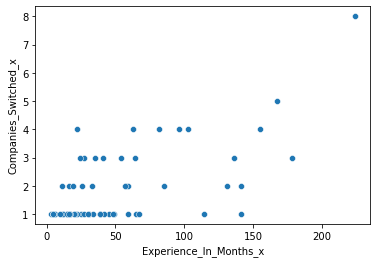

In [22]:
sns.scatterplot(x="Experience_In_Months_x", y="Companies_Switched_x", data=exited_emp_list)

In [25]:
employee_Data = pd.concat([exited_emp_list, df5],ignore_index = True)

In [26]:
employee_Data.to_csv('Total_Employee.csv',index=False)

##### 